In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint

In [51]:
image_generator = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.1,
    zoom_range=0.3,
)
image_generator_test = ImageDataGenerator(
    rescale=1./255.
)

In [52]:
train_data = image_generator.flow_from_directory(
    'data',
    target_size=(500, 500),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=10
)

Found 550 images belonging to 2 classes.


In [53]:
test_data = image_generator_test.flow_from_directory(
    'test_data',
    target_size=(500, 500),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=10
)

Found 74 images belonging to 2 classes.


In [54]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [57]:
train_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [58]:
compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)

array([1.39593909, 0.77903683])

In [59]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)

In [60]:
class_weights = dict(zip(np.unique(train_data.classes), weights))

In [61]:
class_weights

{np.int32(0): np.float64(1.3959390862944163),
 np.int32(1): np.float64(0.7790368271954674)}

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=0.001)

In [63]:
mch = ModelCheckpoint('chestxray.h5', monitor='val_loss', mode='min', save_best_only=True)

In [64]:
history = model.fit(train_data, steps_per_epoch=len(train_data), epochs=30, validation_data=test_data, validation_steps=len(test_data), callbacks=[es, rlrop, mch], class_weight=class_weights)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5111 - loss: 0.8974

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.5120 - loss: 0.8948 - val_accuracy: 0.5000 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6289 - loss: 0.7143

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.6284 - loss: 0.7185 - val_accuracy: 0.6622 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6266 - loss: 0.6511

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.6262 - loss: 0.6513 - val_accuracy: 0.7162 - val_loss: 0.6346 - learning_rate: 0.0010
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.6026 - loss: 0.7348 - val_accuracy: 0.5676 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.6508 - loss: 0.7059 - val_accuracy: 0.5135 - val_loss: 0.7932 - learning_rate: 0.0010
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6079 - loss: 0.6416

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.6088 - loss: 0.6410 - val_accuracy: 0.7297 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.6847 - loss: 0.5733 - val_accuracy: 0.6216 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6586 - loss: 0.5778

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6594 - loss: 0.5772 - val_accuracy: 0.7432 - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7753 - loss: 0.4996

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.7748 - loss: 0.5018 - val_accuracy: 0.8784 - val_loss: 0.3182 - learning_rate: 0.0010
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.6059 - loss: 2.8444 - val_accuracy: 0.4595 - val_loss: 32.8650 - learning_rate: 0.0010
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.6303 - loss: 53.8504 - val_accuracy: 0.4324 - val_loss: 25.4058 - learning_rate: 0.0010
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.5596 - loss: 42.4847 - val_accuracy: 0.5946 - val_loss: 13.6082 - learning_rate: 0.0010
Epoch 13/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.5026 - loss: 26.8524 - val_accuracy: 0.5270 - val_loss: 29.3815 - learning_rate: 0.0010
Epoch 14/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5691 - loss: 12.8554 - val_accuracy: 0.7162 - val_loss: 5.9493 - learning_rate: 0.0010


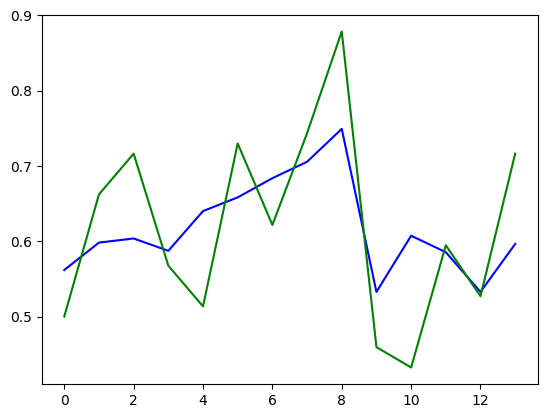

In [65]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='green')

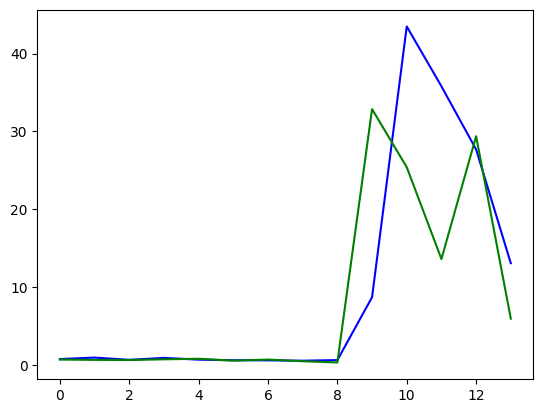

In [66]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='green')

In [67]:
# --------------------------------- Restart Kernel

In [68]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

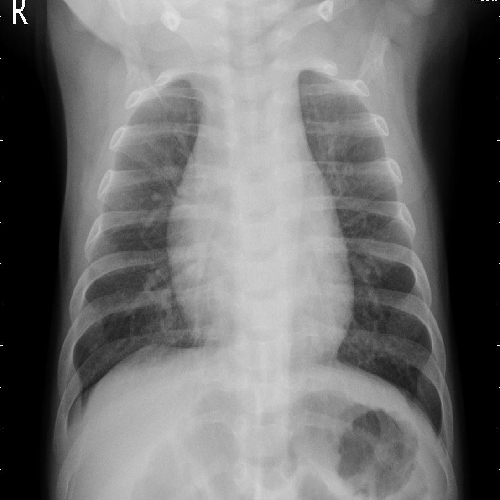

In [69]:
img = load_img('test_data/opacity/person1653_virus_2859.jpeg', target_size=(500, 500), color_mode='grayscale')
img

In [70]:
img = img_to_array(img)
img

array([[[16.],
        [17.],
        [18.],
        ...,
        [ 0.],
        [ 6.],
        [ 5.]],

       [[16.],
        [16.],
        [17.],
        ...,
        [21.],
        [ 3.],
        [ 0.]],

       [[15.],
        [16.],
        [17.],
        ...,
        [ 4.],
        [21.],
        [ 0.]],

       ...,

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]]], dtype=float32)

In [71]:
model = load_model('chestxray.h5')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 498, 498, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 247, 247, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 123, 123, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 121, 121, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,889,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,962,915 (26.56 MB)

 Trainable params: 6,962,913 (26.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [72]:
import tensorflow as tf
model.predict(tf.expand_dims(img, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[1.]], dtype=float32)

In [73]:
preds = model.predict(tf.expand_dims(img, axis=0))
if float(preds[0][0]) > 0.5:
    print('Virus')
else:
    print('Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Virus
